<a href="https://colab.research.google.com/github/rafaellsma/adsense-analysis/blob/main/adsense-anlysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ADWORDS Analysis [by Query Explorer](https://ga-dev-tools.appspot.com/query-explorer)

Através da plataforma Query Explorer, obtivemos um dataset que une os produtos do Google (Analytics/Search Console/AdWords) com informações sobre anuncios direcionados as buscas relacionadas a Farmácia.

Dividimos o trabalho em etapas, sendo a primeira a de pré-processamento do dataset. Limpando outliers, removendo dados irrelevantes e tratando dados importantes ausentes essa etapa é uma das mais importantes pois servirá de base para as demais.

Em seguida, apresentaremos estatísticas descritivas com visualizaçcões e teste de hipotestes para comparar categorias, visando extrair informações para o modelo de negócio.

In [1]:
import numpy as np
import pandas as pd
import requests
import warnings
from numpy import log10
from scipy import stats

import seaborn as sbn
import matplotlib.pyplot as plt

from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.palettes import Spectral6
from bokeh.plotting import figure
from bokeh.transform import factor_cmap
from bokeh.models import ColumnDataSource

output_notebook()

pd.options.display.max_columns = None
pd.options.display.max_rows = None
warnings.filterwarnings('ignore')

Loading BokehJS ...

In [2]:
dataset = pd.read_csv("dataset 210316.csv", sep=";")

In [3]:
print(dataset.shape)
dataset.head()

(21306, 36)


,dateHourMinute,adMatchedQuery,city,latitude,longitude,networkDomain,networkLocation,users,flashVersion,javaEnabled,language,screenResolution,screenName,browser,operatingSystem,mobileDeviceInfo,adSlot,adMatchType,adFormat,adTargetingType,adwordsCriteriaID,impressions,adClicks,adCost,CPM,CPC,CTR,costPerConversion,sessionDuration,organicSearches,goal1Starts,pageviews,uniquePageviews,timeOnPage,exits,pageLoadTime
0,201901150113,comprar terramicina polimixina b,Carpina,"-7,845","-35,2437",planaltonet.net.br,planalto net,1,(not set),No,pt-br,640x360,farmacia12.com.br/index2.html,Chrome,Android,Asus X00LD Zenfone 4 Selfie ZD553KL,Google search: Top,Broad match,Text,Keyword,309449757504,0,0,0,0,0,0,0,0.0,0,1,1,1,0,1,0
1,201901150752,remedios homeopaticos onde comprar,Recife,"-8,0522","-34,9286",(not set),claro s.a.,1,(not set),No,pt-br,360x760,farmacia12.com.br/,Chrome,Android,(not set),Google search: Other,Phrase match,Text,Keyword,1639245696,1,1,"0,03",30,"0,03",100,"0,03",23.0,0,1,3,2,23,1,0
2,201901150753,farmácia são paulo olinda estoque,Recife,"-8,0522","-34,9286",(not set),telef nica brasil s.a,1,(not set),No,pt-br,360x640,farmacia12.com.br/,Chrome,Android,Motorola Moto G (4) Moto G4,Google search: Top,Phrase match,Text,Keyword,10334511,1,1,"0,27",270,"0,27",100,0,0.0,0,0,1,1,0,1,0
3,201901150754,farmacia independente olinda,Olinda,"-7,9906","-34,8417",(not set),claro s.a.,1,(not set),No,pt-br,360x640,farmacia12.com.br/,Chrome,Android,Samsung SM-A520F Galaxy A5 (2017),Google search: Top,Broad match,Text,Keyword,384100548605,1,1,"0,27",270,"0,27",100,"0,27",15.0,0,1,3,2,15,1,0
4,201901150801,qual o remédio certo correto para tirar dor no...,Igarassu,"-7,8333","-34,9128",naveganet.com.br,naveganet comercio e servi os ltda,1,(not set),No,pt-br,360x720,farmacia12.com.br/,Chrome,Android,(not set),Google search: Top,Phrase match,Text,Keyword,12772586,1,1,"0,27",270,"0,27",100,"0,27",11.0,0,1,2,2,11,1,0


Boa parte dos tipos estão como object, então iremos ajustar-los para tipos mais adequados como: string, category, float, int

In [4]:
dataset.dateHourMinute = pd.to_datetime(dataset.dateHourMinute, format="%Y%m%d%H%M")
dataset.adMatchedQuery = dataset.adMatchedQuery.astype('str')
dataset.city = dataset.city.astype('category')
dataset.latitude = dataset.latitude.astype('str').str.replace(',', '.').astype('float64')
dataset.longitude = dataset.longitude.astype('str').str.replace(',', '.').astype('float64')
dataset.networkDomain = dataset.networkDomain.astype('category')
dataset.networkLocation = dataset.networkLocation.astype('category')
dataset.flashVersion = dataset.flashVersion.astype('category')
dataset.javaEnabled = dataset.javaEnabled.replace({True: 'Yes', False: 'No'}).astype('bool')
dataset.language = dataset.language.astype('category')
dataset.screenResolution = dataset.screenResolution.astype('category')
dataset.screenName = dataset.screenName.astype('category')
dataset.browser = dataset.browser.astype('category')
dataset.operatingSystem = dataset.operatingSystem.astype('category')
dataset.mobileDeviceInfo = dataset.mobileDeviceInfo.astype('category')
dataset.adSlot = dataset.adSlot.astype('category')
dataset.adMatchType = dataset.adMatchType.astype('category')
dataset.adFormat = dataset.adFormat.astype('category')
dataset.adTargetingType = dataset.adTargetingType.astype('category')
dataset.adwordsCriteriaID = dataset.adwordsCriteriaID.astype('category')
dataset.impressions = dataset.impressions.astype('int64')
dataset.adClicks = dataset.adClicks.astype('int64')
dataset.adCost = dataset.adCost.astype('str').str.replace(',', '.').astype('float64')
dataset.CPM = dataset.CPM.astype('str').str.replace(',', '.').astype('float64')
dataset.CPC = dataset.CPC.astype('str').str.replace(',', '.').astype('float64')
dataset.CTR = dataset.CTR.astype('str').str.replace(',', '.').astype('float64')
dataset.costPerConversion = dataset.costPerConversion.astype('str').str.replace(',', '.').astype('float64')
dataset.sessionDuration = dataset.sessionDuration.astype('int64')

Vamos usar `.describe` para analisar todos o dados categoricos e ver o que tem valor ou não para o nosso dataset

In [5]:
dataset.describe(include=['category'])

,city,networkDomain,networkLocation,flashVersion,language,screenResolution,screenName,browser,operatingSystem,mobileDeviceInfo,adSlot,adMatchType,adFormat,adTargetingType,adwordsCriteriaID
count,21306,21306,21306,21306,21306,21306,21306,21306,21306,21306,21306,21306,21306,21306,21306
unique,72,90,279,6,31,213,13,13,6,702,5,4,2,2,277
top,Olinda,(not set),(not set),(not set),pt-br,360x640,farmacia12.com.br/,Chrome,Android,Apple iPhone,Google search: Top,Broad match,Text,Keyword,10334511
freq,8271,10839,6581,21299,20777,10198,20113,18725,19885,1342,17154,14380,21287,21287,1696


A coluna city tem 72 valores distintos, isso significa que tem mais cidades do que queremos trabalhar, pois só queremos as cidades da região metropolitana do recife, então vamos filtra-las

In [6]:
allowed_cities = [
    'Abreu e Lima', 
    'Cabo de Santo Agostinho', 
    'Camaragibe', 
    'Goiana', 
    'Igarassu', 
    'Itamaraca', 
    'Ipojuca', 
    'Itapissuma',
    'Jaboatao dos Guararapes',
    'Moreno',
    'Olinda',
    'Paulista',
    'Recife',
    'Sao Lourenco da Mata'
]

dataset = dataset[dataset.city.isin(allowed_cities)]

In [7]:
dataset.describe(include=['category'])

,city,networkDomain,networkLocation,flashVersion,language,screenResolution,screenName,browser,operatingSystem,mobileDeviceInfo,adSlot,adMatchType,adFormat,adTargetingType,adwordsCriteriaID
count,18792,18792,18792,18792,18792,18792,18792,18792,18792,18792,18792,18792,18792,18792,18792
unique,14,64,238,6,28,201,12,13,6,667,5,4,2,2,267
top,Olinda,(not set),(not set),(not set),pt-br,360x640,farmacia12.com.br/,Chrome,Android,Apple iPhone,Google search: Top,Broad match,Text,Keyword,10334511
freq,8271,9251,6248,18785,18318,8927,17758,16545,17561,1158,14961,12644,18775,18775,1514


Temos muitos `(not set)` que são os null nas colunas `networkDomain`, `networkLocation` e `flashVersion`, e essas colunas não agregam muito ao nosso dataset, então iremos apaga-las. Temos 28 valores diferente para `language` e isso não parece fazer muito sentido, pois filtramos só por cidades da RMR, e como ela não agrega muito valor ao nosso dataset, iremos apagar-la.

Outra coluna que podemos apagar é adwordsCriteriaID, pois são id unicos gerados pelo google e para esse projeto não iremos usar-los

In [8]:
dataset = dataset.drop(columns=['networkDomain', 'networkLocation', 'flashVersion', 'language', 'adwordsCriteriaID'])

In [9]:
dataset.describe(include=['category'])

,city,screenResolution,screenName,browser,operatingSystem,mobileDeviceInfo,adSlot,adMatchType,adFormat,adTargetingType
count,18792,18792,18792,18792,18792,18792,18792,18792,18792,18792
unique,14,201,12,13,6,667,5,4,2,2
top,Olinda,360x640,farmacia12.com.br/,Chrome,Android,Apple iPhone,Google search: Top,Broad match,Text,Keyword
freq,8271,8927,17758,16545,17561,1158,14961,12644,18775,18775


Algumas colunas tem poucos valores únicos, e iremos analisar-las usando `.value_counts()` para entender o que esse valores significam.

In [10]:
print(dataset.screenName.value_counts())
print()
print(dataset.browser.value_counts())
print()
print(dataset.operatingSystem.value_counts())
print()
print(dataset.adSlot.value_counts())
print()
print(dataset.adMatchType.value_counts())
print()
print(dataset.adFormat.value_counts())
print()
print(dataset.adTargetingType.value_counts())
print()

farmacia12.com.br/                                                                                                                                                                                                                                                 17758
farmacia12.com.br/index2.html                                                                                                                                                                                                                                        832
farmacia12.com.br/pagar.html                                                                                                                                                                                                                                          98
farmacia12.com.br/lista_medicamento.html                                                                                                                                                                     

A partir da célula acima conseguimos observamar que algumas colunas, `screenName`, `adFormat` e `adTargetingType` tem valores unários, então podemos remover-las.

ScreenName tem valores unários pois todos esses dados são de uma única farmácia, então todos os anuncios são direcionados para o site dela. `adForma` e `adTargetingType` são uninário pois todos os anuncios são para o buscador do google e lá só se mostra o texto.

In [11]:
dataset = dataset.drop(columns=['screenName', 'adFormat', 'adTargetingType'])

In [12]:
dataset.describe(include=['boolean'])

,javaEnabled
count,18792
unique,1
top,True
freq,18792


Vamos olhar agora para os dados numéricos do nosso dataset e ver o que é relevante ou não, e tentar identificar erros nos nosso dados.

In [13]:
dataset.describe(include=['number'], percentiles=[.25, .5, .75, .9, .99])

,latitude,longitude,users,impressions,adClicks,adCost,CPM,CPC,CTR,costPerConversion,sessionDuration,organicSearches,goal1Starts,pageviews,uniquePageviews,timeOnPage,exits,pageLoadTime
count,18792.00000,18792.000000,18792.000000,18792.000000,18792.000000,18792.000000,1.879200e+04,18792.000000,1.879200e+04,18792.000000,18792.000000,18792.000000,18792.000000,18792.000000,18792.000000,18792.000000,18792.000000,18792.000000
mean,-8.00488,-34.881276,1.001117,1.150649,1.003140,1.611762,3.951189e+14,0.211555,2.117012e+14,0.864692,71.284217,0.000958,0.706950,3.097435,2.014527,71.255428,0.994785,124.123138
std,0.04519,0.040569,0.033411,1.266024,0.492443,127.672850,3.594422e+15,0.118098,2.071043e+15,88.354133,187.347568,0.032610,0.468312,2.416688,1.001490,181.734060,0.187339,1701.595126
min,-8.39810,-35.104500,1.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,-8.05220,-34.928600,1.000000,1.000000,1.000000,0.140000,1.200000e+02,0.130000,1.000000e+02,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000
50%,-7.99060,-34.873500,1.000000,1.000000,1.000000,0.260000,2.500000e+02,0.240000,1.000000e+02,0.144200,14.000000,0.000000,1.000000,3.000000,2.000000,14.000000,1.000000,0.000000
75%,-7.99060,-34.841700,1.000000,1.000000,1.000000,0.310000,3.100000e+02,0.300000,1.000000e+02,0.280000,58.000000,0.000000,1.000000,4.000000,2.000000,59.000000,1.000000,0.000000
90%,-7.93760,-34.841700,1.000000,2.000000,2.000000,0.380000,3.800000e+02,0.340000,2.000000e+02,0.340000,171.000000,0.000000,1.000000,6.000000,3.000000,173.000000,1.000000,0.000000
99%,-7.93760,-34.841700,1.000000,7.000000,2.000000,0.700000,1.309998e+16,0.440000,6.666670e+15,0.680000,1030.090000,0.000000,1.000000,12.000000,5.000000,989.270000,2.000000,0.000000
max,-7.56300,-34.841700,2.000000,21.000000,5.000000,12635.000000,5.783330e+16,1.030000,7.692310e+16,12058.000000,2937.000000,2.000000,3.000000,49.000000,10.000000,2937.000000,3.000000,76721.000000


`users`, como nós já esperávamos - como temos lat, lng, deviceInfo esperavamos que cada linha represetava um único usuário - é unário(1 até o p99), então decidimos em remover-la.

`CPM` e `CPC` são duas métricas de monetizacão de anúncios que decidirmos por não utilizar nesse projeto.

`CTR` é uma métrica super importante que parece está errada no nosso dataset, então iremos remover essa coluna e recalcular-la usando adClick/impressions

`organicSearches` é praticamente unário(0 até o p99), então nós decidimos em remover-la.

`goal1Starts` é praticamente unário(0 até o p99), então nós decidimos em remover-la.

`uniquePageviews` é uma coluna que não compreendemos bem, então optamos por remover-la

`exits` tem uma distribuição muito parecida com `adClicks`, então optamos por remover-la e a nossa taxa de rejeição sera baseado pelo tempo na página.

`pageLoadTime` foi uma decepção para o projeto, pois estavamos esperançoso para relacionar a taxa de rejeição com o tempo para carregar a pagina, mas temos menos de 1% de instancias com valores diferentes de 0. Vamos remover-la também

`sessionDuration` e `timeOnPage` são iguais, então iremos manter apenas `timeOnPage`

`impressions` iremos remover todas as instancias com 0 impressões pois cada instancia deveria representar 1 ou mais impressões.

`costPerConversion` não temos mais dados sobre conversão e não temos certeza da acuracia dessa coluna, então iremos remover-la.

In [14]:
dataset = dataset.drop(columns=['users', 'CPM', 'CPC', 'CTR', 'organicSearches', 'goal1Starts', 'uniquePageviews', 'exits', 'pageLoadTime', 'sessionDuration', 'costPerConversion'])

In [15]:
dataset = dataset[dataset.impressions > 0]

In [16]:
dataset['ctr'] = dataset.adClicks.divide(dataset.impressions)
dataset.ctr = dataset.ctr.fillna(0)

In [17]:
dataset.describe(include='all', datetime_is_numeric=True)

,dateHourMinute,adMatchedQuery,city,latitude,longitude,javaEnabled,screenResolution,browser,operatingSystem,mobileDeviceInfo,adSlot,adMatchType,impressions,adClicks,adCost,pageviews,timeOnPage,ctr
count,16745,16745,16745,16745.000000,16745.000000,16745,16745,16745,16745,16745,16745,16745,16745.000000,16745.000000,16745.000000,16745.000000,16745.000000,16745.000000
unique,NaN,10659,14,NaN,NaN,1,186,13,6,647,4,3,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,farmacia pague menos,Olinda,NaN,NaN,True,360x640,Chrome,Android,Apple iPhone,Google search: Top,Broad match,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,344,7207,NaN,NaN,16745,8170,15040,15667,1010,13484,11276,NaN,NaN,NaN,NaN,NaN,NaN
mean,2019-10-11 09:00:21.126307072,NaN,NaN,-8.005151,-34.881921,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.291311,1.125769,1.808792,3.149298,70.519737,1.025961
min,2019-01-15 07:52:00,NaN,NaN,-8.398100,-35.104500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,2019-04-18 17:05:00,NaN,NaN,-8.052200,-34.928600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,0.180000,1.000000,0.000000,1.000000
50%,2019-07-31 21:44:00,NaN,NaN,-7.990600,-34.873500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,0.270000,3.000000,15.000000,1.000000
75%,2020-03-27 15:16:00,NaN,NaN,-7.990600,-34.841700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,0.320000,4.000000,61.000000,1.000000
max,2021-03-13 21:15:00,NaN,NaN,-7.563000,-34.841700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.000000,5.000000,12635.000000,26.000000,2937.000000,3.000000


Uma coluna que quase passou despercebida foi `javaEnabled`, ela está completamente setada como true, então iremos remover-la.

In [18]:
dataset = dataset.drop(columns=['javaEnabled'])

Iremos remover todos os `(not set)` de colunas categoricas ou object

In [19]:
print(dataset.shape)
for column in dataset.columns:
    if dataset.dtypes[column].name == 'category' or dataset.dtypes[column].name == 'object':
        dataset = dataset[(dataset[column] != '(not set)')]
        if dataset.dtypes[column].name == 'category':
            dataset[column].cat.remove_unused_categories(inplace=True)
print(dataset.shape)
dataset.reset_index(drop=True, inplace=True)

(16745, 17)
(16183, 17)


Agora vamos discretizar o `screenResolution` em 4 bins: small, medium, large, xlarge

In [20]:
def transformScreenResolutionInDPI(resolution):
    x = resolution.split('x')
    return int(x[0]) * int(x[1])
    return 0
    
dataset['screenResolutionDist'] = pd.cut(dataset.screenResolution.apply(transformScreenResolutionInDPI), 4, labels=['small', 'medium', 'large', 'xlarge'])

Com a lat/lng iremos usar um geocoding reverso para trazer a granularidade de bairro(locality) para o dataset

In [21]:
cache = dict()

def getLocality(*args):
    if args in cache:
        return cache[args]
    request = requests.get(f'https://api.bigdatacloud.net/data/reverse-geocode-client?latitude={args[0]}&longitude={args[1]}&localityLanguage=pt')
    result = request.json()['locality']
    cache[args] = result
    return result

dataset['locality'] = dataset.apply(lambda x: getLocality(x.latitude, x.longitude), axis=1)

In [22]:
dataset = dataset.drop(columns=['latitude', 'longitude'])

In [23]:
print(dataset.locality.value_counts())
print(dataset.city.value_counts())

Casa Caiada                  7015
Cordeiro                     6195
Paulista                     2795
Abreu e Lima                   40
Igarassu                       35
São Lourenço da Mata           30
Piedade                        29
Centro                         14
Camaragibe                     11
Cidade Criança Área Rural       6
Moreno                          4
Goiana                          4
Ipojuca                         4
Ilha de Itamaracá               1
Name: locality, dtype: int64
Olinda                     7015
Recife                     6195
Paulista                   2795
Abreu e Lima                 40
Igarassu                     35
Sao Lourenco da Mata         30
Jaboatao dos Guararapes      29
Cabo de Santo Agostinho      14
Camaragibe                   11
Itapissuma                    6
Moreno                        4
Ipojuca                       4
Goiana                        4
Itamaraca                     1
Name: city, dtype: int64


Como podemos ver na célula acima, todas a lat/lng são unicas por cidade. Tentamos entender o que ouve, mas ja chegou assim do analytics para gente. Acreditamos que seja algum mecanismo para preservar a privacidade do usuário.

Removendo duplicados do dataset

In [24]:
dataset.drop_duplicates(inplace=True)

In [25]:
dataset.describe(include=['number'], percentiles=[0.25, 0.5, 0.75, 0.9, 0.99])

,impressions,adClicks,adCost,pageviews,timeOnPage,ctr
count,16183.000000,16183.000000,16183.000000,16183.000000,16183.000000,16183.000000
mean,1.291726,1.126429,1.862046,3.145770,70.580362,1.026105
std,1.266390,0.367151,137.579015,2.404589,176.207464,0.351294
min,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,1.000000,1.000000,0.170000,1.000000,0.000000,1.000000
50%,1.000000,1.000000,0.270000,3.000000,15.000000,1.000000
75%,1.000000,1.000000,0.320000,4.000000,61.000000,1.000000
90%,2.000000,2.000000,0.390000,6.000000,172.800000,1.000000
99%,8.000000,2.000000,0.720000,12.000000,962.000000,2.000000
max,21.000000,5.000000,12635.000000,26.000000,2937.000000,3.000000


Como podemos ver na celula acima temos valores zerados para adClicks, adCost e timeOnPage, então iremos usar algumas tecnicas para tentarmos inserir esses dados ausentes.

In [26]:
dataset.corr(method='spearman')

,impressions,adClicks,adCost,pageviews,timeOnPage,ctr
impressions,1.000000,0.200138,0.019824,0.035394,0.035629,-0.685490
adClicks,0.200138,1.000000,0.375242,0.144702,0.143094,0.531631
adCost,0.019824,0.375242,1.000000,-0.022434,-0.043716,0.237411
pageviews,0.035394,0.144702,-0.022434,1.000000,0.886518,0.078577
timeOnPage,0.035629,0.143094,-0.043716,0.886518,1.000000,0.077993
ctr,-0.685490,0.531631,0.237411,0.078577,0.077993,1.000000


In [27]:
print(dataset.adClicks.describe())
dataset.adClicks = dataset.adClicks.replace(0, dataset.adClicks.median())
print(dataset.adClicks.describe())

count    16183.000000
mean         1.126429
std          0.367151
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          5.000000
Name: adClicks, dtype: float64
count    16183.000000
mean         1.128406
std          0.363756
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          5.000000
Name: adClicks, dtype: float64


In [28]:
print(dataset.adCost.describe())
dataset.adCost = dataset.adCost.replace(0, dataset.adCost.median())
print(dataset.adCost.describe())

count    16183.000000
mean         1.862046
std        137.579015
min          0.000000
25%          0.170000
50%          0.270000
75%          0.320000
max      12635.000000
Name: adCost, dtype: float64
count    16183.000000
mean         1.862580
std        137.579008
min          0.010000
25%          0.170000
50%          0.270000
75%          0.320000
max      12635.000000
Name: adCost, dtype: float64


Como `timeOnPage` tem uma forte correlação com `pageviews`, itemos usar um knn para inputar essa coluna

In [29]:
from sklearn.impute import KNNImputer
aux = dataset[['timeOnPage', 'pageviews']].replace(0, np.nan)
print(aux.describe())
imputer = KNNImputer(n_neighbors=5)
imputer.fit(aux)
x = imputer.transform(aux)
x = pd.DataFrame(x, columns = ['timeOnPage', 'pageviews'])
print(x.describe())
dataset[['timeOnPage', 'pageviews']] = x

         timeOnPage     pageviews
count  11849.000000  16183.000000
mean      96.396489      3.145770
std      199.794971      2.404589
min        1.000000      1.000000
25%       12.000000      1.000000
50%       32.000000      3.000000
75%       92.000000      4.000000
max     2937.000000     26.000000
         timeOnPage     pageviews
count  16183.000000  16183.000000
mean     147.220763      3.145770
std      190.885873      2.404589
min        1.000000      1.000000
25%       16.000000      1.000000
50%       67.000000      3.000000
75%      288.200000      4.000000
max     2937.000000     26.000000


In [30]:
print(dataset.shape)
dataset.describe(include=['number'], percentiles=[0.25, 0.5, 0.75, 0.9, 0.99])

(16183, 17)


,impressions,adClicks,adCost,pageviews,timeOnPage,ctr
count,16183.000000,16183.000000,16183.000000,16183.000000,16183.000000,16183.000000
mean,1.291726,1.128406,1.862580,3.145770,147.220763,1.026105
std,1.266390,0.363756,137.579008,2.404589,190.885873,0.351294
min,1.000000,1.000000,0.010000,1.000000,1.000000,0.000000
25%,1.000000,1.000000,0.170000,1.000000,16.000000,1.000000
50%,1.000000,1.000000,0.270000,3.000000,67.000000,1.000000
75%,1.000000,1.000000,0.320000,4.000000,288.200000,1.000000
90%,2.000000,2.000000,0.390000,6.000000,288.200000,1.000000
99%,8.000000,2.000000,0.720000,12.000000,962.000000,2.000000
max,21.000000,5.000000,12635.000000,26.000000,2937.000000,3.000000


Agora iremos detectar outliers em nossos atributos categóricos.

impressions       AxesSubplot(0.125,0.657941;0.227941x0.222059)
adClicks       AxesSubplot(0.398529,0.657941;0.227941x0.222059)
adCost         AxesSubplot(0.672059,0.657941;0.227941x0.222059)
pageviews         AxesSubplot(0.125,0.391471;0.227941x0.222059)
timeOnPage     AxesSubplot(0.398529,0.391471;0.227941x0.222059)
ctr            AxesSubplot(0.672059,0.391471;0.227941x0.222059)
dtype: object

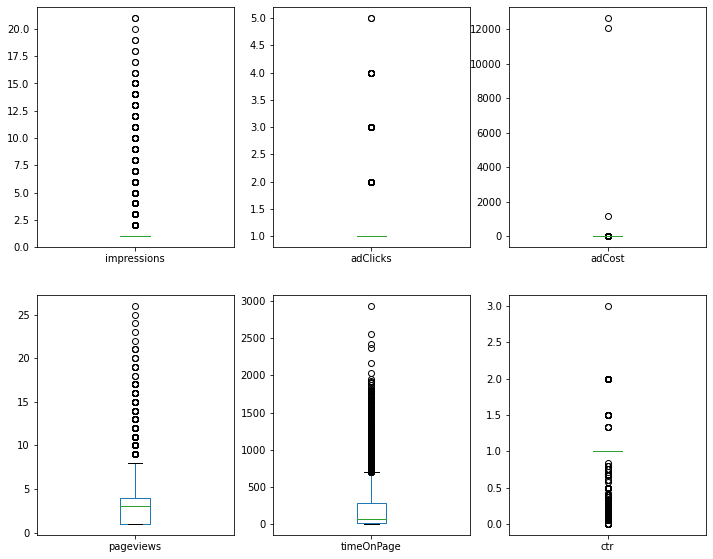

In [31]:
dataset.plot.box(subplots=True, layout=(3,3), figsize=(12,15))

In [32]:
from numpy import abs

def histToRobustZScore(s):
    ((abs(log10(s)-log10(s).median())) / log10(s).mad()).plot.hist()
    
def removeBasedOnRobustZScore(s, score):
    return s[((abs(log10(s)-log10(s).median())) / log10(s).mad()) < score]
            
def removeBasedOnTukey(s):
    q1 = log10(s).quantile(0.25)
    q3 = log10(s).quantile(0.75)
    iqr = q3-q1
    return s[(log10(s) >= (q1-1.5*iqr)) & (log10(s) <= (q3+1.5*iqr))]

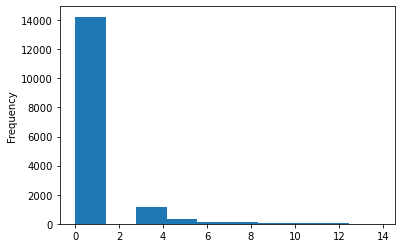

In [33]:
histToRobustZScore(dataset.impressions)

<AxesSubplot:>

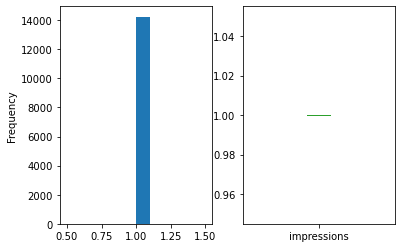

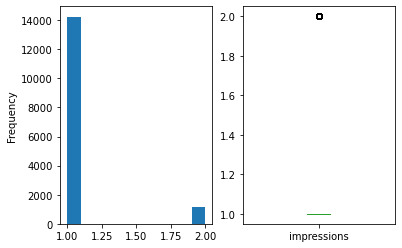

In [34]:
fig, axes = plt.subplots(1, 2)
removeBasedOnTukey(dataset.impressions).plot.hist(ax=axes[0])
removeBasedOnTukey(dataset.impressions).plot.box(ax=axes[1])
fig, axes = plt.subplots(1, 2)
removeBasedOnRobustZScore(dataset.impressions, 3.5).plot.hist(ax=axes[0])
removeBasedOnRobustZScore(dataset.impressions, 3.5).plot.box(ax=axes[1])

In [35]:
# Escolhemos usar o tukey
dataset.impressions = removeBasedOnTukey(dataset.impressions)

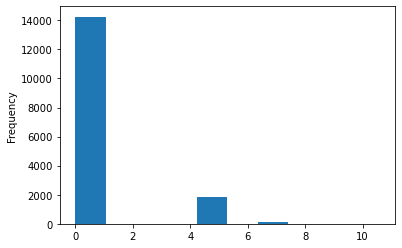

In [36]:
histToRobustZScore(dataset.adClicks)

<AxesSubplot:>

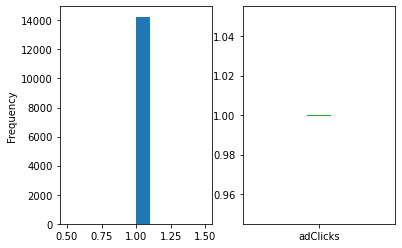

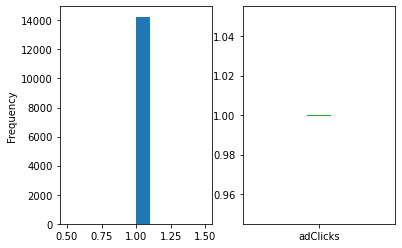

In [37]:
fig, axes = plt.subplots(1, 2)
removeBasedOnTukey(dataset.adClicks).plot.hist(ax=axes[0])
removeBasedOnTukey(dataset.adClicks).plot.box(ax=axes[1])
fig, axes = plt.subplots(1, 2)
removeBasedOnRobustZScore(dataset.adClicks, 3.5).plot.hist(ax=axes[0])
removeBasedOnRobustZScore(dataset.adClicks, 3.5).plot.box(ax=axes[1])

In [38]:
# Escolhemos usar o z-score robusto com 3.5 de threshold
dataset.adClicks = removeBasedOnRobustZScore(dataset.adClicks, 3.5)

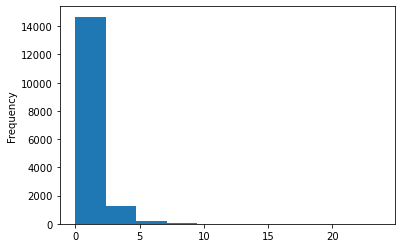

In [39]:
histToRobustZScore(dataset.adCost)

<AxesSubplot:>

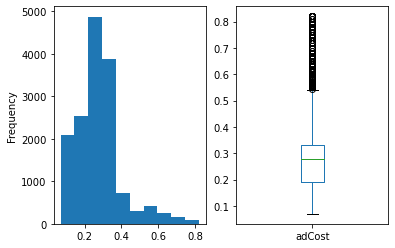

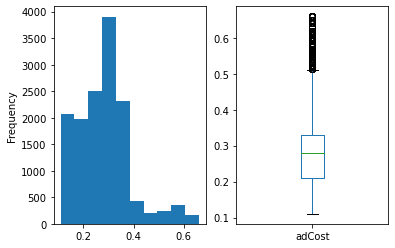

In [40]:
fig, axes = plt.subplots(1, 2)
removeBasedOnTukey(dataset.adCost).plot.hist(ax=axes[0])
removeBasedOnTukey(dataset.adCost).plot.box(ax=axes[1])
fig, axes = plt.subplots(1, 2)
removeBasedOnRobustZScore(dataset.adCost, 2).plot.hist(ax=axes[0])
removeBasedOnRobustZScore(dataset.adCost, 2).plot.box(ax=axes[1])

In [41]:
# Escolhemos usar o z-score robusto com 2 de threshold
dataset.adCost = removeBasedOnRobustZScore(dataset.adCost, 2)

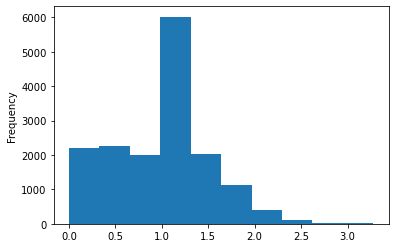

In [42]:
histToRobustZScore(dataset.timeOnPage)

<AxesSubplot:>

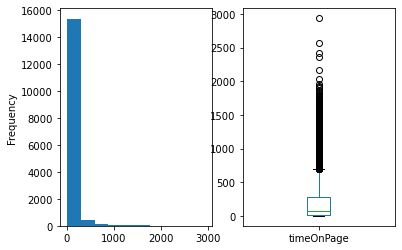

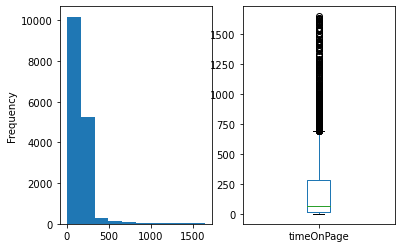

In [43]:
fig, axes = plt.subplots(1, 2)
removeBasedOnTukey(dataset.timeOnPage).plot.hist(ax=axes[0])
removeBasedOnTukey(dataset.timeOnPage).plot.box(ax=axes[1])
fig, axes = plt.subplots(1, 2)
removeBasedOnRobustZScore(dataset.timeOnPage, 2.5).plot.hist(ax=axes[0])
removeBasedOnRobustZScore(dataset.timeOnPage, 2.5).plot.box(ax=axes[1])

In [44]:
# Escolhemos usar o z-score robusto com 2.5 de threshold
dataset.timeOnPage = removeBasedOnRobustZScore(dataset.timeOnPage, 2.5)

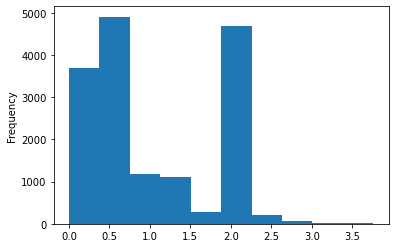

In [45]:
histToRobustZScore(dataset.pageviews)

<AxesSubplot:>

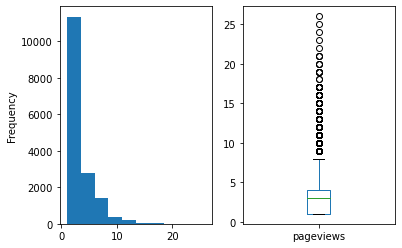

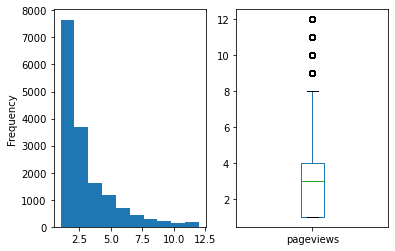

In [46]:
fig, axes = plt.subplots(1, 2)
removeBasedOnTukey(dataset.pageviews).plot.hist(ax=axes[0])
removeBasedOnTukey(dataset.pageviews).plot.box(ax=axes[1])
fig, axes = plt.subplots(1, 2)
removeBasedOnRobustZScore(dataset.pageviews, 2.5).plot.hist(ax=axes[0])
removeBasedOnRobustZScore(dataset.pageviews, 2.5).plot.box(ax=axes[1])

In [47]:
# Escolhemos usar o z-score robusto com 2.5 de threshold
dataset.pageviews = removeBasedOnRobustZScore(dataset.pageviews, 2.5)

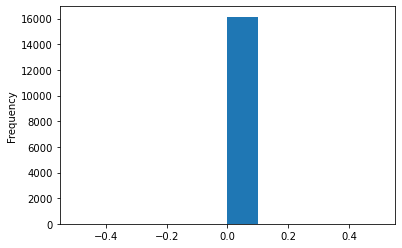

In [48]:
histToRobustZScore(dataset.ctr)

<AxesSubplot:>

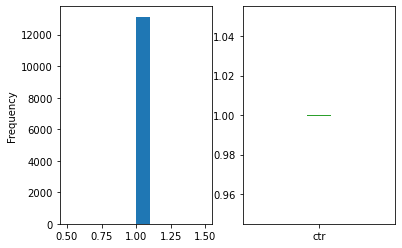

In [49]:
fig, axes = plt.subplots(1, 2)
removeBasedOnTukey(dataset.ctr).plot.hist(ax=axes[0])
removeBasedOnTukey(dataset.ctr).plot.box(ax=axes[1])

In [50]:
# Escolhemos usar o z-score robusto com 2.5 de threshold
dataset.ctr = removeBasedOnTukey(dataset.ctr)

impressions       AxesSubplot(0.125,0.657941;0.227941x0.222059)
adClicks       AxesSubplot(0.398529,0.657941;0.227941x0.222059)
adCost         AxesSubplot(0.672059,0.657941;0.227941x0.222059)
pageviews         AxesSubplot(0.125,0.391471;0.227941x0.222059)
timeOnPage     AxesSubplot(0.398529,0.391471;0.227941x0.222059)
ctr            AxesSubplot(0.672059,0.391471;0.227941x0.222059)
dtype: object

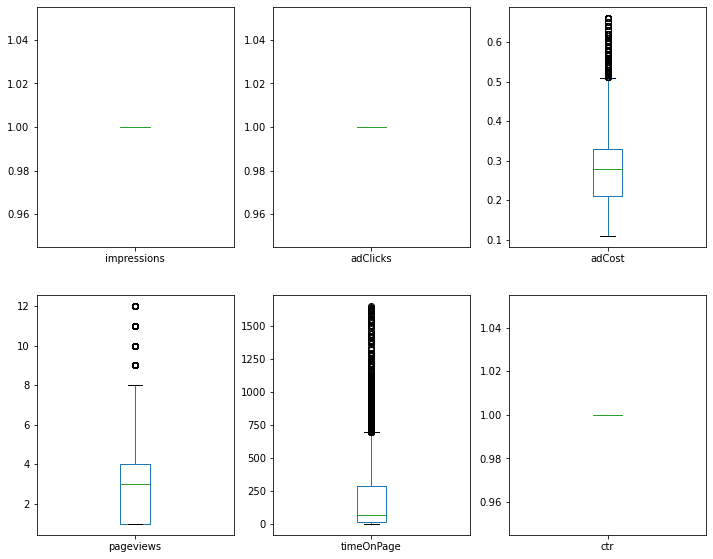

In [51]:
dataset.plot.box(subplots=True, layout=(3,3), figsize=(12,15))

### Distribuição preço dos anuncios

<AxesSubplot:xlabel='adCost', ylabel='Density'>

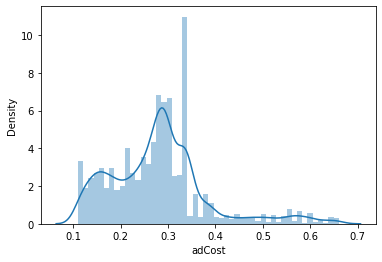

In [52]:
sbn.distplot(dataset.adCost)

<AxesSubplot:xlabel='adCost', ylabel='Density'>

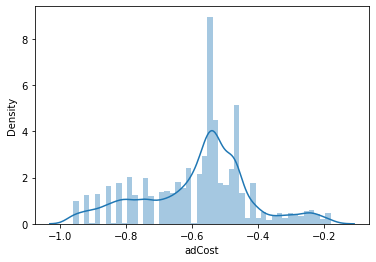

In [53]:
x = dataset.adCost
sbn.distplot(x.apply(log10))

### Preço médio de anúncio por cidade

<AxesSubplot:ylabel='city'>

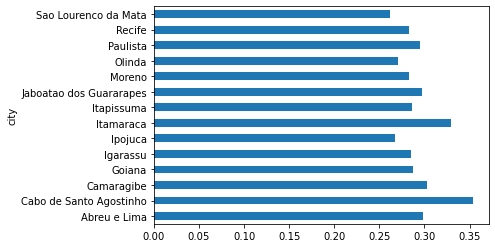

In [54]:
dataset.groupby(by='city').mean().adCost.dropna().plot.barh()

### Preço do anúncio por tempo na página

<AxesSubplot:xlabel='adCost', ylabel='timeOnPage'>

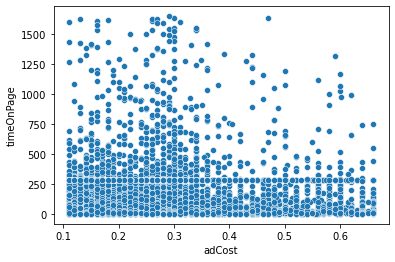

In [55]:
sbn.scatterplot(x=dataset.adCost, y=dataset.timeOnPage)

<AxesSubplot:xlabel='adCost', ylabel='timeOnPage'>

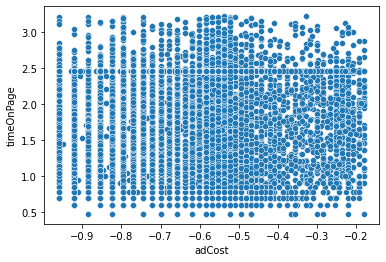

In [56]:
x = dataset.adCost
y = dataset.timeOnPage
sbn.scatterplot(x=x.apply(log10), y=y.apply(log10))

Não existe correlação entre o tempo na página e o preço do anuncio

### Distribuição tempo na página

<AxesSubplot:xlabel='timeOnPage', ylabel='Density'>

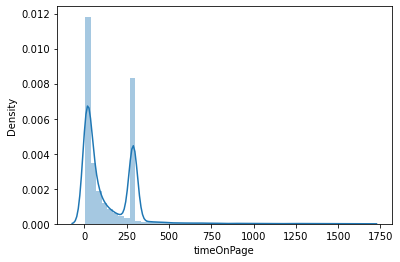

In [57]:
sbn.distplot(dataset.timeOnPage)

<AxesSubplot:ylabel='Density'>

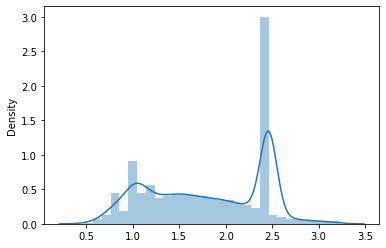

In [58]:
x = dataset.timeOnPage
sbn.distplot(x=x.apply(log10))

### Tempo na página por resolução de tela

<AxesSubplot:ylabel='screenResolutionDist'>

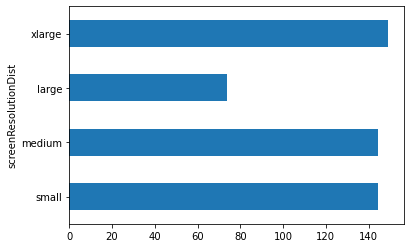

In [63]:
dataset.groupby(by='screenResolutionDist').mean().timeOnPage.dropna().plot.barh()

### Tempo na página por sistema operacional

<AxesSubplot:ylabel='operatingSystem'>

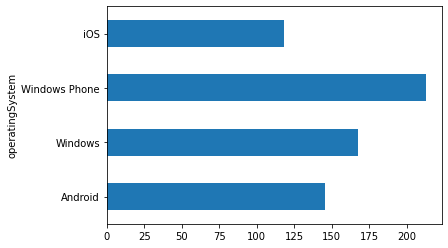

In [64]:
dataset.groupby(by='operatingSystem').mean().timeOnPage.dropna().plot.barh()

### Preço de anuncio por sistema operacional

<AxesSubplot:ylabel='operatingSystem'>

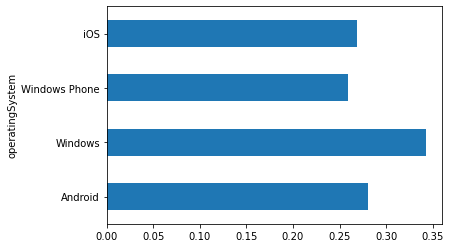

In [65]:
dataset[dataset.adCost < 1].groupby(by='operatingSystem').mean().adCost.dropna().plot.barh()

### Pagina vistadas por tempo médio na pagina

<AxesSubplot:ylabel='pageviews'>

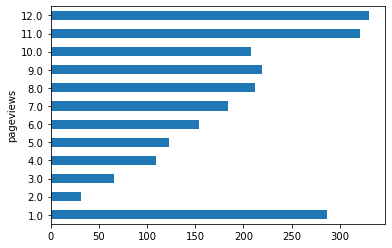

In [70]:
dataset.groupby(by='pageviews').mean().timeOnPage.dropna().plot.barh()

Apenas uma págin